In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# About the Data

These datasets are taken from [Kaggle: Airbnb New User Bookings](https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data). The data was collected from the users over at United States, and is to be used to predict new user behaviours and their first activities. But I am goint to use this data to try and look at insights about new user behaviours and provide Buisness Stratergies for the companies growth in USA

### Datesets:

* **countries.csv** : summary statistics of destination countries in this dataset and their locations
* **age_gender_bkts.csv** : summary statistics of users' age group, gender, country of destination
* **sessions.csv** : web sessions log for users
    - user_id: to be joined with the column 'id' in users table
    - action
    - action_type
    - action_detail
    - device_type
    - secs_elapsed
---
* **other** training, testing and submittion datasets for the prediction model

# Data Wrangling


Skip to the [Inferential Statistics](#inferential-stats)

### Age, Gender and Population Statistics

In [9]:
df_agb = pd.read_csv('datasets/age_gender_bkts.csv')
df_agb

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


In [10]:
df_agb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


This dataset has no null values amongst its features.

In [11]:
# Converting age = 100+ into a bin
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)

# Defining 'mean_age' feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [12]:
df_agb

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0
...,...,...,...,...,...
415,US,male,115.0,2015.0,97.0
416,US,male,541.0,2015.0,92.0
417,US,female,10570.0,2015.0,17.0
418,US,male,1441.0,2015.0,87.0


In [13]:
df_agb.mean_age.unique()

array([102.,  97.,  92.,  87.,  82.,  77.,  72.,  67.,  62.,  57.,  52.,
        47.,  42.,  37.,  32.,  27.,  22.,  17.,  12.,   7.,   2.])

In [14]:
df_agb['country_destination'].value_counts()

AU    42
CA    42
DE    42
ES    42
FR    42
GB    42
IT    42
NL    42
PT    42
US    42
Name: country_destination, dtype: int64

In [15]:
df_agb['gender'].value_counts()

male      210
female    210
Name: gender, dtype: int64

In [16]:
# turning gender into a categorical binary variable
# male: 0, female: 1
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x =='male' else 1)
df_agb['gender'].value_counts()

0    210
1    210
Name: gender, dtype: int64

In [17]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

In [18]:
# dropping year feature as it doesn't all much information

df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Country Statistics

In [19]:
df_country = pd.read_csv('datasets/countries.csv')
df_country

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [20]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


This dataset also doesn't have any null values. The dtypes are also good enough for modeling and exploratory data analysis.

### Sessions

In [21]:
df_sessionssionssions = pd.read_csv('datasets/sessions.csv')
df_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In this dataset, although some values are already NaN, many of the values can be seen as having the value -unknown- which has to be replaces by NaN to make sense of them.

In [22]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [23]:
df_sessions.user_id.unique()

array(['d1mm9tcy42', 'yo8nz8bqcq', '4grx6yxeby', ..., 'fa6260ziny',
       '87k0fy4ugm', '9uqfg8txu3'], dtype=object)

In [24]:
# checking if there are any other values other than -unknown- which may be needed to change to NaN

df_sessions.action.unique()

array(['lookup', 'search_results', 'personalize', 'index',
       'similar_listings', 'ajax_refresh_subtotal', 'show',
       'header_userpic', 'ask_question', nan,
       'other_hosting_reviews_first', 'hosting_social_proof',
       'decision_tree', 'recent_reservations', 'faq_experiment_ids',
       'multi', 'active', 'dashboard', 'create', 'confirm_email',
       'show_personalize', 'verify', 'pending', 'requested', 'concierge',
       'faq', 'clear_reservation', 'cancellation_policies',
       'track_page_view', 'update', 'my', 'campaigns', 'notifications',
       'listings', 'unavailabilities', 'ajax_lwlb_contact',
       'ajax_check_dates', 'qt2', 'request_new_confirm_email',
       'ajax_photo_widget_form_iframe', 'facebook_auto_login', 'identity',
       'qt_reply_v2', 'travel_plans_current', 'complete_status',
       'populate_from_facebook', 'kba_update', 'kba', 'login',
       'authenticate', 'calendar_tab_inner2', 'other_hosting_reviews',
       'social_connections', 'relat

In [25]:
df_sessions.action_type.unique()

array([nan, 'click', 'data', 'view', 'submit', 'message_post',
       '-unknown-', 'booking_request', 'partner_callback',
       'booking_response', 'modify'], dtype=object)

In [26]:
df_sessions.device_type.unique()

array(['Windows Desktop', '-unknown-', 'Mac Desktop', 'Android Phone',
       'iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet',
       'Linux Desktop', 'Tablet', 'Chromebook', 'Blackberry', 'iPodtouch',
       'Windows Phone', 'Opera Phone'], dtype=object)

In [27]:
# replacing -unknown- with NaN

df_sessions['action'] = df_sessions['action'].replace('-unknown-',np.nan)
df_sessions['action_type'] = df_sessions['action_type'].replace('-unknown-',np.nan)
df_sessions['action_detail'] = df_sessions['action_detail'].replace('-unknown-',np.nan)

# we will deal with 'secs_elapsed' and 'device_type' separately

In [28]:
df_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,NaN,NaN,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,NaN,NaN,-unknown-,17624.0


Looking at 'secs_elapsed'

In [29]:
df_sessions.secs_elapsed.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10567737 entries, 0 to 10567736
Series name: secs_elapsed
Non-Null Count     Dtype  
--------------     -----  
10431706 non-null  float64
dtypes: float64(1)
memory usage: 80.6 MB


In [35]:
len(df_sessions[df_sessions.secs_elapsed.isnull()])

136031

There are 136,031 'sec_elapsed' fields for which we do not know the value. We need to either drop or interpolate these values.

In [30]:
df_sessions.secs_elapsed.describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

Mean: 19,405 secs
Median: 1,147 secs

Hence there may be some outliers in the data which are effecting the average time significanlty.

In [40]:
# replacing NaN to median

df_sessions['secs_elapsed'] = df_sessions['secs_elapsed'].fillna(df_sessions.secs_elapsed.median())

In [41]:
df_sessions.secs_elapsed.describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [43]:
# getting all the rows which have null values

null_val = df_sessions[(df_sessions['action_type'].isnull()) | (df_sessions['action_detail'].isnull()) | (df_sessions['action'].isnull()) ]
null_val.shape

(2237000, 6)

There are over 2.237 M fields that have incomplete information about the action, action type or action detail. This is approximately 20% of the data that we possess. Additionally, there are 270 types of action for which we have null values, so examining them one by one is simply not feasible manually.

Since this is not our training dataset, we will not drop the values. We shall keep because it is possible to extract information even from rows which have null columns.

In [45]:
df_sessions['device_type'] = df_sessions['device_type'].replace('-unknown-', np.nan)
len(df_sessions[df_sessions['device_type'].isnull()])


211279

# Training Data

In [46]:
df_train = pd.read_csv('datasets/train_users_2.csv')
df_train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [47]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [48]:
len(df_train[df_train['first_device_type'].isnull()])

0

The following features in the dataset have no null values:

1. date_account_created
2. timestamp_first_active
3. signup_method
4. signup_flow
5. language
6. affiliate_channel
7. affiliate_provider
8. signup_app
9. first_device_type

The following features in the dataset have null values:

1. date_first_booking
2. gender
3. age
4. first_affiliate_tracked
5. first_browser

In [50]:
df_train[df_train['age'] > 116]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197386,99y83scsje,2014-05-31,20140531031949,2014-05-31,FEMALE,1938.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,US
198888,io7z9esqaj,2014-06-03,20140603074958,2014-10-09,MALE,1924.0,facebook,23,en,direct,direct,untracked,Android,Other/Unknown,NaN,US
206249,zmlbfc7cso,2014-06-17,20140617230607,2014-06-20,FEMALE,1947.0,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,US
208819,0dn4tfj6gw,2014-06-22,20140622214130,NaN,FEMALE,1949.0,basic,0,en,direct,direct,untracked,Moweb,Android Phone,Chrome Mobile,NDF


The oldest living person is 116 years old.
Hence, this is clearly polluted data and must be removed. Let us replace these values with NaN to denote that we do not know the real age of these people.

In [51]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 116 else x)

# Inferential Stats

In this section, we will be applying statistical tools to gain some inferences and insights into the kind of data we are dealing with and disovering relationships between various features of our dataset.

### Gender

Does the gender of a person affect the first country s/he books an Airbnb in?


* We will consider only those users who have enlisted their gender as male or female. Unknown and other genders are not included in this analysis.
* We do not consider users who have never booked an Airbnb or have booked in a country not enlisted as a class (NDF and Other).

In [52]:
df_ins = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_ins = df_ins[['id', 'gender', 'country_destination']]
df_ins

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US
...,...,...,...
213412,a1rvlsdijt,FEMALE,US
213439,msucfwmlzc,MALE,US
213441,omlc9iku7t,FEMALE,ES
213443,0k26r3mir0,FEMALE,US


In [53]:
df_ins['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [54]:
df_ins['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

##### Hypothesis Testing

* **Null Hypothesis** : There is no relationship between country preference and the sex of the customer.
* **Alternate Hypothesis** : There is a relationship between country preference and the sex of the customer.

We will assume our significance level to be 0.05

In [65]:
observed = df_ins.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
observed = observed.set_index('gender')
observed

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [66]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [67]:
chi2

116.87183139602567

In [68]:
p

5.830126955071572e-21


p << 0.05


Accepting the Alternate Hypothesis: There is a relationship between country preference and the sex of the customer.

### Signup

Does the type of device (mobile or computer) affect the signup method to Airbnb?


Assumptions:
* We will ignore the Google Signup Method as there are extremely few instances of it.
* We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [70]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer
...,...,...,...,...
213446,zxodksqpep,basic,Web,Computer
213447,mhewnxesx9,basic,Web,Computer
213448,6o3arsjbb4,basic,Web,Computer
213449,jh95kwisub,basic,iOS,Mobile


In [71]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [72]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

#### Hypothesis Testing

* **Null Hypothesis** : There is no relationship between device type and signup method.
* **Alternate Hypothesis** : There is a relationship between device type and signup method.

Significance level: 0.05

In [73]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


In [74]:
hi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [75]:
chi2

116.87183139602567

In [76]:
p

0.7886788661023779

p < 0.05


Accepting Null Hypothesis: There is no relationship between device type and signup method.

### Conclusions

* There is **a relationship** between gender and Airbnb Country Destination. In other words, the gender influences your country of choice.
* There is **no relationship** between device type and signup method. The two variables are independent of each other.

# Exploratory Data Analysis

Visualizing and summairizing our data to extract new insights about individual features and the relationship they share with the other features.

### Country Stats

(from df_agb)

<AxesSubplot:xlabel='mean_age', ylabel='population_in_thousands'>

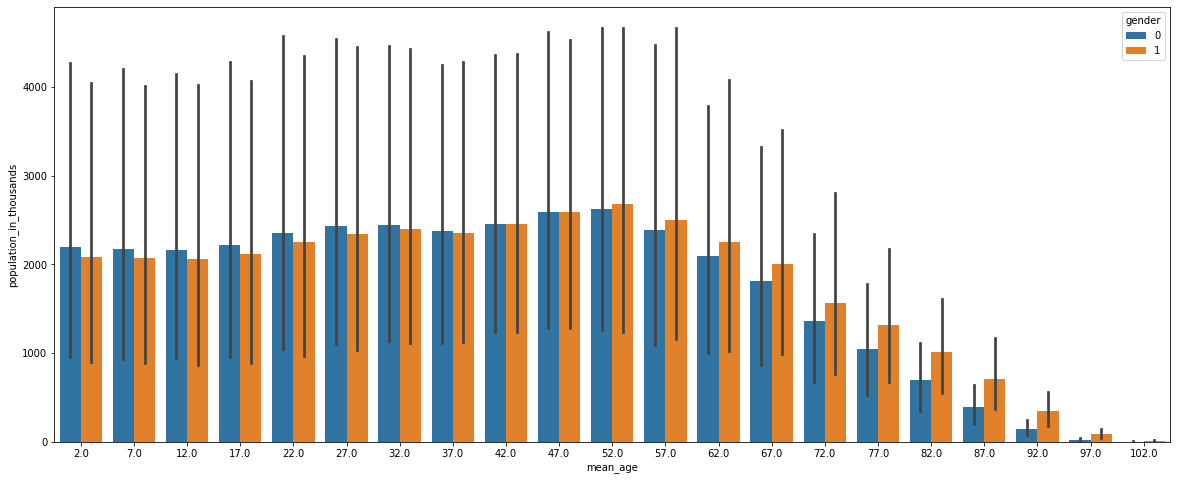

In [78]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb)

<AxesSubplot:xlabel='mean_age', ylabel='population_in_thousands'>

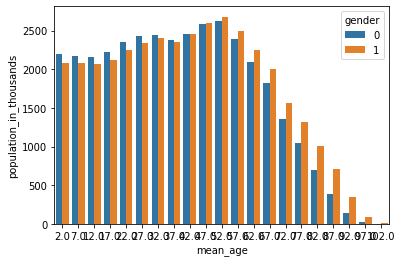

In [79]:
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, errorbar=None)

#### Observations

* User demographic mostly consists of middle aged people with mean ages 47 years and 53 years closely followed by the youth and then the old.
* Sex ratio is skewed towards men for younger age groups but as the mean age increases, the ratio skews more towards women.

<AxesSubplot:xlabel='country_destination', ylabel='population_in_thousands'>

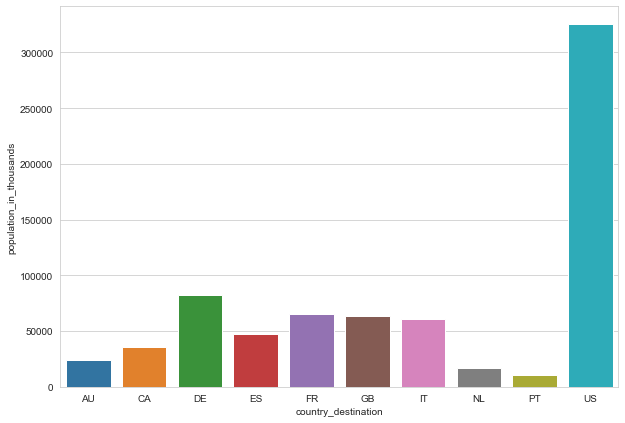

In [80]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

<AxesSubplot:xlabel='country_destination', ylabel='distance_km'>

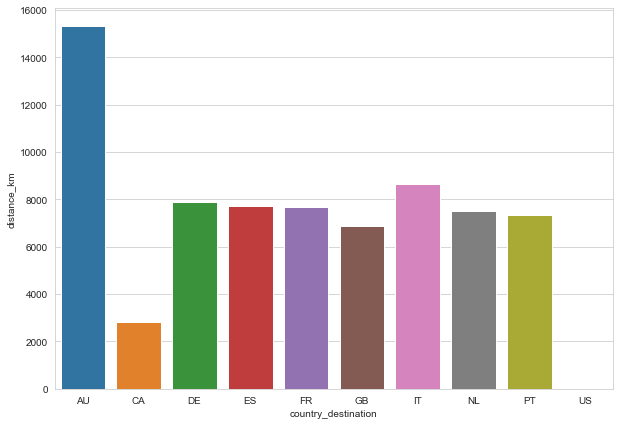

In [82]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_country)

In [83]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [84]:
country_distance = pd.Series(df_country['distance_km'])
country_distance.index = df_country['country_destination']

language_distance = pd.Series(df_country['language_levenshtein_distance'])
language_distance.index = df_country['country_destination']

country_area = pd.Series(df_country['destination_km2'])
country_area.index = df_country['country_destination']

personr = -0.6484642400863146, p = 0.04254889990179413


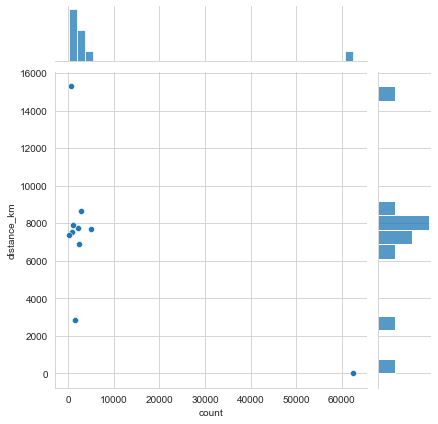

In [91]:
# with USA

df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

r, p = stats.pearsonr(df_dp['count'], df_dp['distance_km'])
print("personr = {}, p = {}".format(r,p))

There is a **strong negative correlation of -0.65.**


Although this data is from the users in USA, people overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

personr = -0.1759446624093568, p = 0.6506866405490176


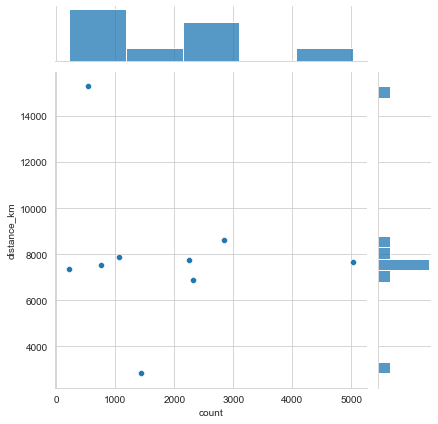

In [92]:
# without USA

sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

r, p = stats.pearsonr(df_dp.drop('US')['count'], df_dp.drop('US')['distance_km'])
print("personr = {}, p = {}".format(r,p))

Much lower correlation after dropping US. However, there is still a negative correlation between the two quantities.

Next, let us check if the language spoken in a particular country influences the number of bookings in that country. To calculate this metric, we will use the **Language Levenshtein Distance** of each country's official language from English already made available to us in the dataframe.

personr = -0.3781984499393646, p = 0.28121470472249055


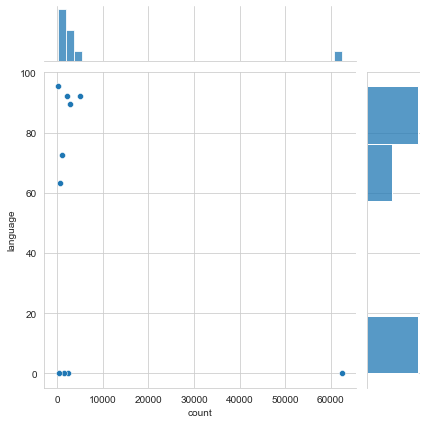

In [95]:
# with USA

sns.jointplot(x='count', y='language', data=df_dp)

r, p = stats.pearsonr(df_dp['count'], df_dp['language'])
print("personr = {}, p = {}".format(r,p))

personr = 0.28423885706521723, p = 0.4585348909455462


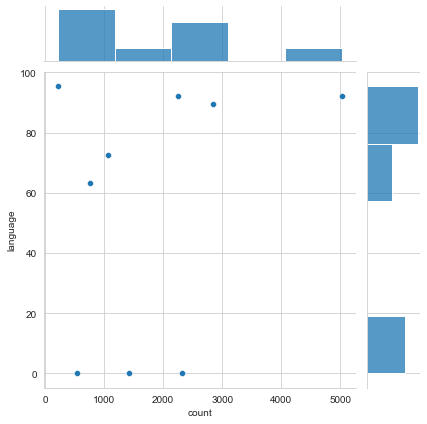

In [96]:
# without USA

sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

r, p = stats.pearsonr(df_dp.drop('US')['count'], df_dp.drop('US')['language'])
print("personr = {}, p = {}".format(r,p))

The result of this visualisation is extremely interesting. 

* We see that when United States is removed from the list of countries, there is actually **a positive correlation** between language distance and booking frequency. 
* At first glance, this may suggest that people prefer countries with different language (and therefore culture) while travelling abroad. 
* Another way of looking at it would be that **Europe is an extremely popular travel destination for Americans** and they tend to prefer it to other English Speaking countries like Canada and Australia. So this may have nothing to do with language difference as it may have to do with destination preference.

Finally, in this section, let us check if the size of the country has anything to do with booking preference. Like the previous two cases, we have data on the size of each country.

personr = 0.5389902049556756, p = 0.10790831227077449


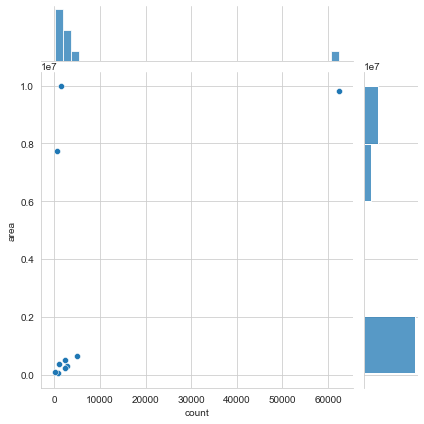

In [98]:
# with USA

sns.jointplot(x='count', y='area', data=df_dp)

r, p = stats.pearsonr(df_dp['count'], df_dp['area'])
print("personr = {}, p = {}".format(r,p))


personr = -0.2572952244245889, p = 0.5039042635493614


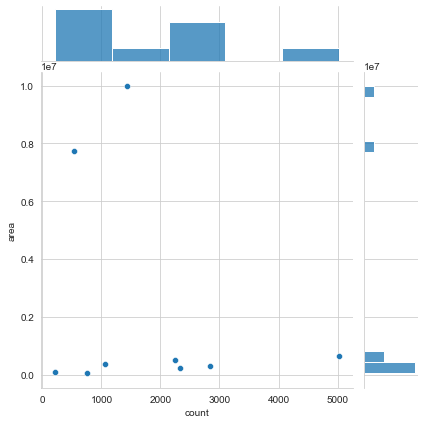

In [99]:
# without USA

sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

r, p = stats.pearsonr(df_dp.drop('US')['count'], df_dp.drop('US')['area'])
print("personr = {}, p = {}".format(r,p))

The results with area closely resemble what we've gained from our tests on language distance. Overall, there is a positive correlation between the size of the country and the booking preference. This is largely because the United States is a large country (the second largest in this list). 

When the US is removed however, the **data showcases a negative correlation.** Again, as with the case of language, this may have nothing to do with country size but destination preference. European countries are usually small in size but extremely popular among American tourists.

### Session Stats

(from df_sessions)

In [102]:
len(df_sessions[df_sessions['secs_elapsed'] < 5000])/len(df_sessions[df_sessions['secs_elapsed'].notnull()])

0.6978051213802917

In [103]:
len(df_sessions[df_sessions['secs_elapsed'] < 10000])/len(df_sessions[df_sessions['secs_elapsed'].notnull()])

0.771633037423244

In [104]:
len(df_sessions[df_sessions['secs_elapsed'] < 1000])/len(df_sessions[df_sessions['secs_elapsed'].notnull()])

0.4672638049186879

This strongly suggests a decreasing exponential distribution of seconds elapsed on each session. In other words, as the number of seconds increases, the number of instances of sessions requiring that much time exponentially decreases.

<AxesSubplot:xlabel='count', ylabel='device_type'>

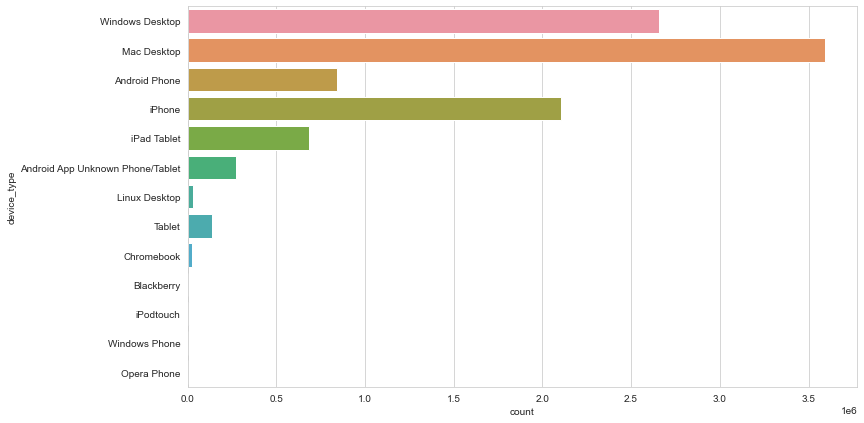

In [105]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_sessions)

The **Mac Desktop** is the most popular device among Airbnb Users, followed by the **Windows Desktop.** An interesting insight is that **Apple Products are extremely popular with Airbnb Users.** The iPhone, iPad and the Mac all appear in the list of top 5 most popular devices.

### User Stats

(from df_trian: main dataset)

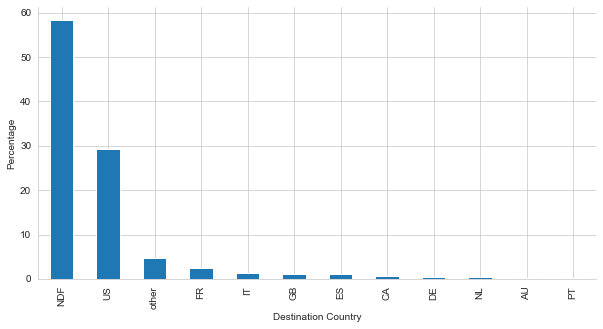

In [106]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

As can be seen above, close to **60% of users have never booked an Airbnb.** Among the users that have, they have overwhelmingly chosen **United States as their first destination.**

#### Stacked Bar Viz

A stacked bar chart gives us a collection of proportionately colored bars where each color represents a class (or the destination). Since there are more than 10 classes, I chose to forego the legend. The colors we are concerned with are **dark blue (bottom bar) which corresponds to the NDF class** and **blue (second bottom bar) which corresponds to the US Class**. As we have already seen, these two classes form the majority and therefore, will occupy most of the area of each bar. Each bar has been normalized with respect to its size.

In [107]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

#### Gender

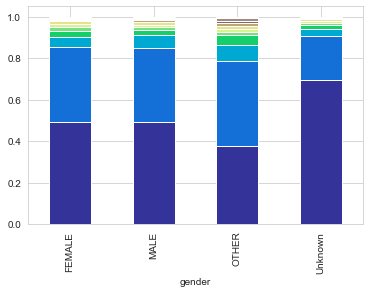

In [113]:
stacked_bar('gender')

One very interesting point of note is that **people who haven't marked their gender are less likely to book an Airbnb.** Also, people who have marked themselves as **'other' are more likely** than any other group to make a booking. This might not be a very potent insight since the other group is a negligible proportion of the population.

#### Age

In [114]:
# creating different bins based on ages

def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [115]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

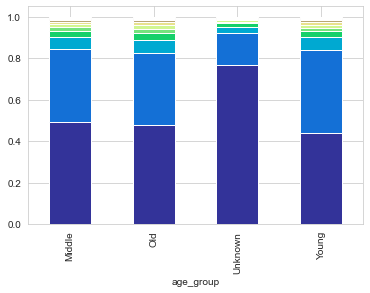

In [116]:
stacked_bar('age_group')

We discover that people who have not disclosed their ages **are least likely to book an Airbnb.**

#### Signup Method

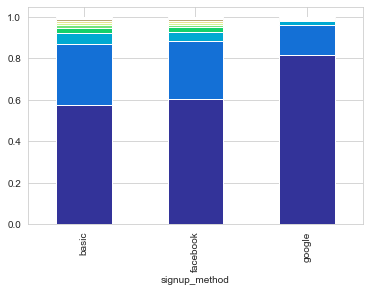

In [117]:
stacked_bar('signup_method')

People who use **basic** signup method are most likely to book an Airbnb whereas people who use **google** are least likely to make a booking.

#### Language

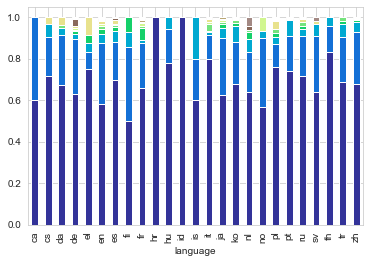

In [118]:
stacked_bar('language')

* People who speak **Hungarian** and **Indonesian** made almost no bookings.
* People who spoke **Finnish** made the most bookings amongst all languages.


However since the users are American, we can safely assume that the non English users consitute a minortiy.

#### Affiliate Channels

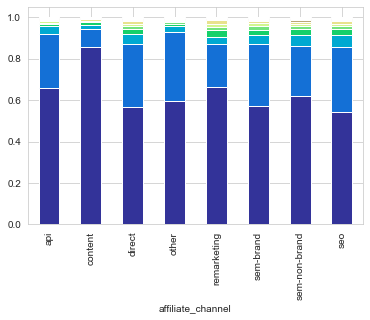

In [119]:
stacked_bar('affiliate_channel')

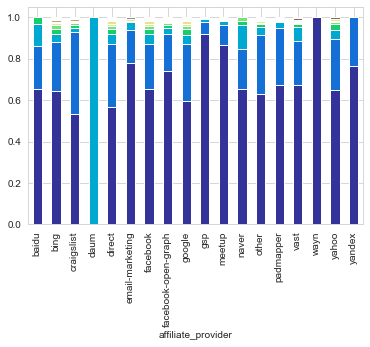

In [122]:
stacked_bar('affiliate_provider')

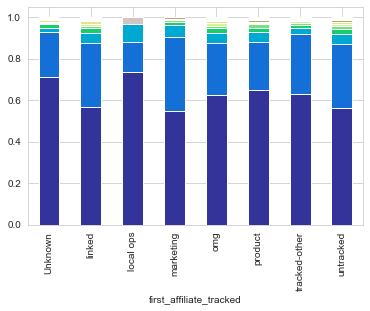

In [123]:
stacked_bar('first_affiliate_tracked')

Some observations from the above visualisations:
* The **Direct Channel** has the most number of conversions to bookings whereas the **Content Channel** has the least.
* **Direct** and **Google** are the most popular affiliate providers.
* **Wayn** has the least percentage of conversions whereas **Daum** has the most.
* Apart from the above, **Google** and **Craigslist** have a good percentage of conversions.
* People with **Marketing** afilliates were most likely to book. People whose first affiliate was tracked as **Local Ops** or was **Unknown** were least likely.

#### Signup Flow

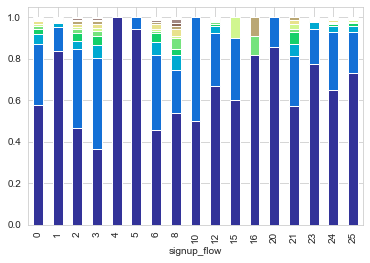

In [124]:
stacked_bar('signup_flow')

#### Signup App

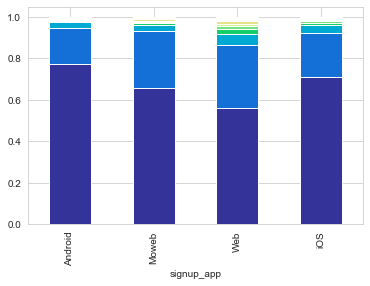

In [125]:
stacked_bar('signup_app')

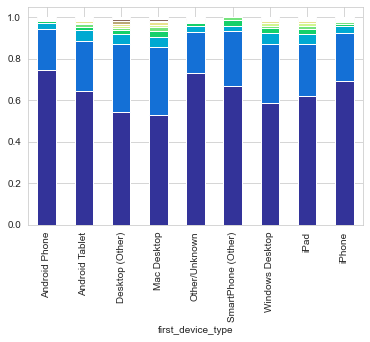

In [126]:
stacked_bar('first_device_type')

* Users using the **Web App** are most likely to book an Airbnb whereas **Android Users** are least likely to do so.
* **People with an Android Phone or whose devices were unknown** bought fewer Airbnbs. People on Desktops (Mac or otherwise) bought more.

# Conclusion

Buisness Recomendations: Refer to slides